In [1]:
import torch
import torch.nn as nn
import pandas as pd

# 1. ViT

In [2]:
BATCH_SIZE = 512
PATCH_SIZE = 4
EMB_DIM = 192

IMG_SIZE = 28
IMG_DEPTH = 1
NUM_CLASSES = 10

NUM_HEADS = 4
HIDDEN_DIM = 768
DROP_OUT_RATE = 0.1

WD = 0
LR = 4e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_PATH = "./data/train.csv"

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, img_size, in_channel, emb_dim, batch_size):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.in_channel = in_channel
        self.emb_dim = emb_dim
        self.batch_size = batch_size

        self.emb_layer = self._embadding_layer()

        num_patch = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.pos_emb = nn.Parameter(torch.randn(1, num_patch + 1, emb_dim))

    def _embadding_layer(self):
        return nn.Sequential(
            nn.Conv2d(kernel_size=self.patch_size, stride=self.patch_size,
                      in_channels=self.in_channel, out_channels=self.emb_dim),
            # (B, EMB_DIM, img_size / PATCH_SIZE , img_size / PATCH_SIZE)
            nn.Flatten(start_dim=2) 
            # (B, EMB_DIM, 49)
        )

    def forward(self, x):
        x = self.emb_layer(x).transpose(1,2)

        cls_tokens = self.cls_token.expand(self.batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        # (B, 50, EMB_DIM)
        x = x + self.pos_emb
        return x

In [4]:
class ViT(nn.Module):
    def __init__(self, emb_dim, num_heads, hidden_dim, drop_out_rate, 
                 img_size, patch_size, in_channels, num_classes, batch_size=BATCH_SIZE):
        super().__init__()
        self.emb_dim = emb_dim        
        self.num_heads = num_heads
        self.droptout = drop_out_rate
        self.hidden_dim = hidden_dim

        self.embedding = PatchEmbedding(patch_size=patch_size, img_size=img_size, batch_size=batch_size, 
                                        in_channel=in_channels, emb_dim=emb_dim)
        self.encoder = self._make_encoder_layers()
        self.norm = nn.LayerNorm(emb_dim)
        self.mlp_head = nn.Linear(emb_dim, num_classes)
    
    def _make_encoder_layers(self):
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.emb_dim,
            nhead=self.num_heads,
            dim_feedforward=self.hidden_dim,
            dropout=self.droptout,
            batch_first=True
        )
        return nn.TransformerEncoder(encoder_layer, num_layers=2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.norm(x)
        # (B, 50, EMB_DIM)
        cls_token = x[:, 0, :] # (B, EMB_DIM)
        return self.mlp_head(cls_token)

# 2. Dataset

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        label = int(row['label'])
        pixels = torch.tensor(row.iloc[1:].values, dtype=torch.float32)
        image = pixels.view(1, 28, 28) 

        return image, label

In [6]:
from torch.utils.data import random_split

dataset = Dataset(CSV_PATH)
print(len(dataset))

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

42000


In [7]:
# Test
# test_vit = ViT(EMB_DIM, NUM_HEADS, HIDDEN_DIM, DROP_OUT_RATE, IMG_SIZE, PATCH_SIZE, 
#           in_channels=IMG_DEPTH, num_classes=NUM_CLASSES, batch_size=1)

# loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# for image, label in loader:
#     out = test_vit(image)
#     break

# 3. Train

In [8]:
EPOCHS = 500

In [9]:
from tqdm import tqdm
from tqdm import trange

In [10]:
def train_fn(train_loader, model, optimizer, loss_fn, show_progress=False):
    loop = tqdm(train_loader, leave=True) if show_progress else train_loader
    losses = []

    for _, (img, label) in enumerate(loop):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        out = model(img)

        loss = loss_fn(out, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if show_progress:
            loop.set_postfix(loss=loss.item())

    mean_loss = sum(losses) / len(losses)
    return mean_loss


In [11]:
def validate(loader, model, loss_fn, show_progress=False):
    model.eval()
    loop = tqdm(loader, leave=True) if show_progress else loader
    losses = []

    with torch.no_grad():
        for _, (img, label) in enumerate(loop):
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            out = model(img)
            loss = loss_fn(out, label)
            losses.append(loss.item())

            if show_progress:
                loop.set_postfix(loss=loss.item())

    mean_loss = sum(losses) / len(losses)
    model.train()
    return mean_loss


In [12]:
model = ViT(EMB_DIM, NUM_HEADS, HIDDEN_DIM, DROP_OUT_RATE, IMG_SIZE, PATCH_SIZE, 
          in_channels=IMG_DEPTH, num_classes=NUM_CLASSES)
model = model.to(DEVICE)

optim = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
loss = nn.CrossEntropyLoss()

In [13]:
# small_dataset, val_small_dataset, _ = random_split(dataset, [5000, 1000, len(dataset) - 6000])
# small_loader = torch.utils.data.DataLoader(small_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_small_loader = torch.utils.data.DataLoader(val_small_dataset, batch_size=BATCH_SIZE, shuffle=True)

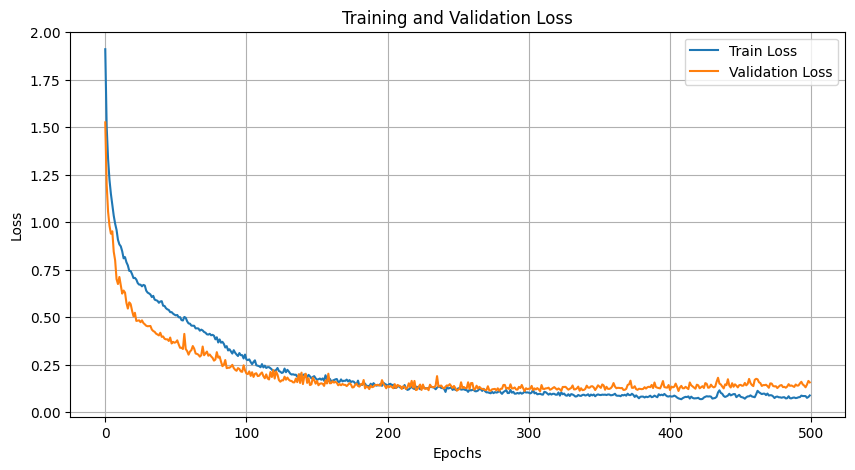

Training: 100%|██████████| 500/500 [1:03:18<00:00,  7.60s/it]


In [14]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_path = None

for epoch in trange(EPOCHS, desc="Training"):
    for x, y in train_loader:
        x = x.to(DEVICE)

    train_loss = train_fn(train_loader, model, optim, loss)
    val_loss = validate(val_loader, model, loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"best_model_epoch{epoch + 1}.pt")
        if best_model_path is not None and os.path.exists(best_model_path):
            os.remove(best_model_path)
        best_model_path = f"best_model_epoch{epoch + 1}.pt"

    # ✅ Live plot in Jupyter
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# 4. Generate Prediction

In [13]:
TEST_CSV_PATH = "./data/test.csv"
WEIGHT_PATH = "./weights/0_4e-4_0.3.pt"

In [14]:
test_model = ViT(EMB_DIM, NUM_HEADS, HIDDEN_DIM, DROP_OUT_RATE, IMG_SIZE, PATCH_SIZE, 
          in_channels=IMG_DEPTH, num_classes=NUM_CLASSES, batch_size=1)
test_model.to(DEVICE)

state_dict = torch.load(WEIGHT_PATH, weights_only=True)
test_model.load_state_dict(state_dict)

test_model.eval()

ViT(
  (embedding): PatchEmbedding(
    (emb_layer): Sequential(
      (0): Conv2d(1, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): Flatten(start_dim=2, end_dim=-1)
    )
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
        )
        (linear1): Linear(in_features=192, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=768, out_features=192, bias=True)
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (mlp_head): Linear(in_features=192, out_features=

In [15]:
test_df = pd.read_csv(TEST_CSV_PATH)
test_df.insert(0, 'label', range(1, len(test_df) + 1)) # To reuse the current dataset, "label" column is used
test_df.to_csv("./data/test_with_image_id.csv", index=False)

test_dataset = Dataset("./data/test_with_image_id.csv")
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False)

In [17]:
results = []
for img, img_id  in test_loader:
    x = img.to(DEVICE)
    out = test_model(x)
    out = int(torch.argmax(out))
    results.append(out)

In [19]:
submission = pd.DataFrame({
    "ImageId":test_df["label"],
    "Label":results,
})

print(submission)
submission.to_csv("./data/submission.csv", index=False)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      9
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]
